In [39]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Concordance of Single Partitions vs. Combined Results

[Partitioning of the groups to improve runtime](http://jvivian.github.io/notebooks/Pairwise-DESeq2-Parition-Method-and-Concordance.html) (by up to 97% faster), reduces the concordance of the gene ranks compared to the traditional method, which is not run pairwise. 

Let's first examine how similar results are between analyses of a single partition size and the combined results.

For example, TCGA breast cancer has 113 normal and 1092 tumor samples. For a partition size of $p = 16$, we're comparing the gene ranks of a single comparison of 113 to 16, vs the pairwise method averaging over all 1092 samples.

In [78]:
def rank(ref_genes, genes_to_rank):
    temp = {}
    ranks = []
    inter = set(ref_genes).intersection(set(genes_to_rank))
    ref_genes = [x for x in ref_genes if x in inter]
    genes_to_rank = [x for x in genes_to_rank if x in inter]
    for i, gene in enumerate(ref_genes):
        temp[gene] = i
    for gene in genes_to_rank:
        ranks.append(temp[gene])
    return ranks

def plot_ranks(ref_genes, genes_to_rank, title, ax):
    ranks = rank(ref_genes, genes_to_rank)
    x = np.array([x for x in xrange(len(ranks))])
    y = np.array(ranks)
    sns.regplot(x, y, ax=ax, scatter_kws={'alpha':0.03})
    ax.set_title(title)

In [9]:
breast = {int(x.split('-')[1][:-4]): pd.read_csv('max-chunk-results/' + x, sep='\t', index_col=0) 
          for x in os.listdir("max-chunk-results/") if 'breast' in x}

single_partition = {int(x.split('-')[0]): pd.read_csv('max-chunk-results/one-part-chunk/' + x, sep='\t', index_col=0) 
                    for x in os.listdir("max-chunk-results/one-part-chunk/")}

breast_np = pd.read_csv('nonpairwise-results/breast.tsv', sep='\t', index_col=0)

### Concordance of Single Partition Compared to Combined Results 

For a given partition size, we'll compare a single partition's results to the combined results of that partition size over all samples.

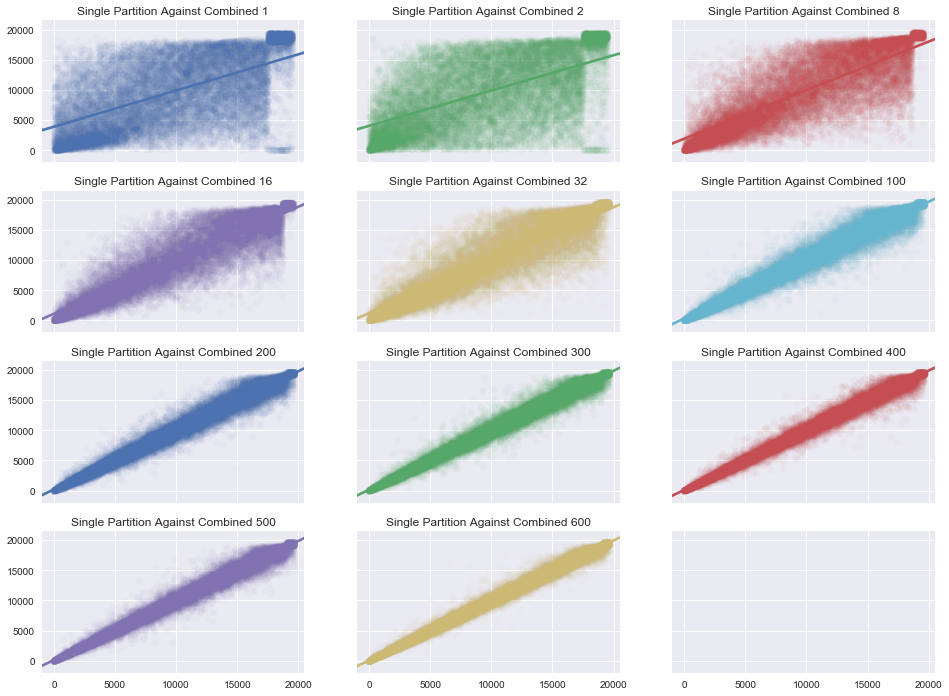

In [37]:
f, axes = plt.subplots(4, 3, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()
for i, p in enumerate(sorted(single_chunks.keys(), key=lambda x: int(x))):
    plot_ranks(breast[p].sort_values('pval').gene_id, single_partition[p].index, 
               'Single Partition Against Combined ' + str(p), axes[i])

### PearsonR of Single Partition vs. Combined Results

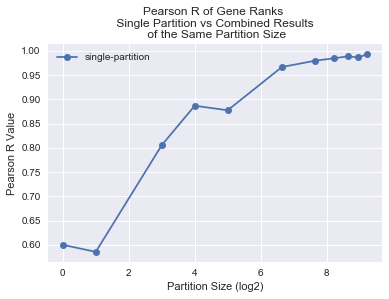

In [63]:
single_ps = []
for p in sorted(single_partition.keys(), key=lambda x: int(x)):
    r = rank(single_partition[p].index, breast[p].sort_values('pval').gene_id)
    single_ps.append(pearsonr(np.array([x for x in xrange(len(r))]), np.array(r))[0])    
plt.plot(np.log2([int(x) for x in sorted(single_partition.keys(), key=lambda x: int(x))]), single_ps, 
         label='single-partition', marker='o')
plt.xlabel('Partition Size (log2)')
plt.ylabel('Pearson R Value')
plt.legend()
plt.title('Pearson R of Gene Ranks \n Single Partition vs Combined Results \n of the Same Partition Size');

### PearsonR of Single Partition / Combined Results vs. Traditional Method

More interestingly, how much does a single partition's results deviate from the traditional method _relative_ to the combined results? Imagine we have two groups of 1,000 we'd like to compare. The runtime can be drastically improved while maintaining reasonable concordance using the partition method, but what if the results could be approximated by randomly selecting ~100 samples from each group for a comparison? 

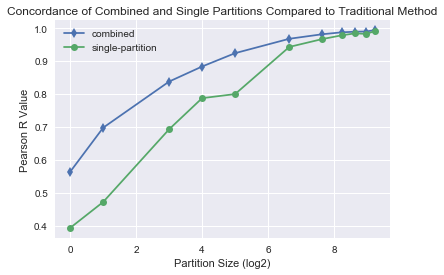

In [76]:
single_ps = []
combined_ps = []

for p in sorted(single_partition.keys(), key=lambda x: int(x)):
    r = rank(single_partition[p].index, breast_np.index)
    single_ps.append(pearsonr(np.array([x for x in xrange(len(r))]), np.array(r))[0])
    
    r = rank(breast[p].sort_values('pval').gene_id, breast_np.index)
    combined_ps.append(pearsonr(np.array([x for x in xrange(len(r))]), np.array(r))[0])
    
plt.plot(np.log2([int(x) for x in sorted(single_partition.keys(), key=lambda x: int(x))]), combined_ps, 
         label='combined', marker='d')
plt.plot(np.log2([int(x) for x in sorted(single_partition.keys(), key=lambda x: int(x))]), single_ps, 
         label='single-partition', marker='o')
plt.xlabel('Partition Size (log2)')
plt.ylabel('Pearson R Value')
plt.legend()
plt.title('Concordance of Combined and Single Partitions Compared to Traditional Method');

For our example of Breast tissue, with 113 normal samples and 1092 tumor samples, we reach almost identical results (gene ranks) doing a single comparison of 113N to ~100T, as when we do ten of those comparisons and average over all results.

In [77]:
from IPython.core.display import HTML
HTML("""
<style>
.dataframe * {border-color: #c0c0c0 !important;}
.dataframe th{background: #eee;}
.dataframe td{
    background: #fff;
    text-align: right; 
    min-width:5em;
}

/* Format summary rows */
.dataframe-summary-row tr:last-child,
.dataframe-summary-col td:last-child{
    background: #eee;
    font-weight: 500;
}
.output {
    align-items: center;
}
</style>
""")